In [649]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,StratifiedKFold
import xgboost as xgb
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
import plotly.graph_objs as go
import plotly.express as px
from fancyimpute import KNN, IterativeImputer,SimpleFill 
from lightgbm import LGBMClassifier
from sklearn.impute import KNNImputer


In [650]:
df = pd.read_csv("train.csv")

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
Age - The age of the passenger.
VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
Name - The first and last names of the passenger.
Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

In [651]:
df.drop(columns=["PassengerId","Name","Cabin"],inplace=True)

In [652]:
df["Transported"] = df["Transported"].map({True:1, False:0})

In [653]:
df["Transported"]

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 8693, dtype: int64

In [654]:
X = df.iloc[:,0:10]
y = df["Transported"]

In [655]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.25)

In [656]:
cat_feat = np.array([coluna for coluna in X_train.columns if X_train[coluna].dtype.name == 'object'])

num_feat = np.array([coluna for coluna in X_train.columns if coluna not in cat_feat])

In [658]:
cat_pipe = Pipeline([("imputer_cat", SimpleImputer(strategy="most_frequent")),("encoder", ce.TargetEncoder()),
                    ])

num_pipe = Pipeline([("imputer_num", KNNImputer(n_neighbors=3))])

In [659]:
transformer = ColumnTransformer([("num_trans", num_pipe, num_feat),
                            ("cat_trans", cat_pipe, cat_feat)])

In [660]:
X_train_transformed = transformer.fit_transform(X_train, y_train)
X_test_transformed = transformer.transform(X_test)

In [661]:
models = []

models.append(("xgb",xgb.XGBClassifier()))
models.append(("xgbD",xgb.XGBClassifier(booster="dart")))
models.append(("xgbL",xgb.XGBClassifier(booster="gblinear")))
models.append(("lgbm",LGBMClassifier()))

results = dict()

for  name, model in models:
    skf = StratifiedKFold(n_splits = 5, random_state=None)
    cv_results = cross_val_score(model,X_train_transformed,y_train,cv=skf, scoring="accuracy")
    results[name]= (cv_results.mean(), cv_results.std())

print("name     results.mean     results.std")

for key,value in results.items():
    print(key,value)

[LightGBM] [Info] Number of positive: 2629, number of negative: 2586
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 5215, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504123 -> initscore=0.016491
[LightGBM] [Info] Start training from score 0.016491
[LightGBM] [Info] Number of positive: 2629, number of negative: 2586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1369
[LightGBM] [Info] Number of data points in the train set: 5215, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504123 -> initscore=0.016491
[LightGBM] 

In [662]:
modelo = LGBMClassifier()

In [663]:
modelo.fit(X_train_transformed, y_train)

[LightGBM] [Info] Number of positive: 3286, number of negative: 3233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6519, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504065 -> initscore=0.016261
[LightGBM] [Info] Start training from score 0.016261


LGBMClassifier()

In [664]:
modelo.predict(X_test_transformed)

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

In [665]:
y_pred = modelo.predict(X_test_transformed)

In [666]:
precision = precision_score(y_pred, y_test)
precision

0.8287545787545788

In [667]:
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.7888684452621895

In [668]:
recall = precision_score(y_pred, y_test)
recall

0.8287545787545788

In [669]:
f1 = f1_score(y_pred, y_test)
f1

0.7977082415160864

In [670]:
score = []
score.append(("precision", precision))
score.append(("accuracy",accuracy))
score.append(("recall",recall))
score.append(("f1",f1))

In [671]:
score= pd.DataFrame(score)

In [672]:
score.rename(columns={0: "Metric", 1:"Result"}, inplace=True)

In [673]:
score

,Metric,Result
0,precision,0.828755
1,accuracy,0.788868
2,recall,0.828755
3,f1,0.797708


In [674]:
print(f"Precision: {score.iloc[0,1]:.4f}")
print(f"Accuracy: {score.iloc[1,1]:.4f}")
print(f"F1_Score: {score.iloc[2,1]:.4f}")
print(f"Recall: {score.iloc[3,1]:.4f}")

Precision: 0.8288
Accuracy: 0.7889
F1_Score: 0.8288
Recall: 0.7977


- Precision: 0.8095
- Accuracy: 0.7852
- F1_Score: 0.8095
- Recall: 0.7911

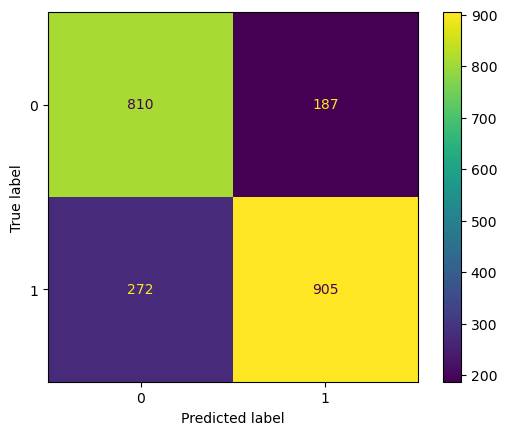

In [675]:
confusions_matrix = confusion_matrix(y_pred, y_test)

from sklearn.metrics import ConfusionMatrixDisplay

conf_disp = ConfusionMatrixDisplay(confusion_matrix=confusions_matrix)

conf_disp.plot()

In [676]:
testecsv = pd.read_csv("testspace.csv")

In [677]:
testecsv

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [678]:
X_teste = testecsv.drop(columns=["PassengerId","Cabin","Name"])


In [679]:
testecsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [680]:
model = modelo

In [681]:
X = transformer.fit_transform(X,y)
X_teste = transformer.transform(X_teste)

In [682]:
model.fit(X, y)

[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495


LGBMClassifier()

In [684]:
y_predz = model.predict(X_teste)

In [685]:
subimisspace = pd.Series(index = testecsv["PassengerId"].values, data = y_predz)

In [686]:
subimisspace = subimisspace.reset_index()

In [687]:
subimisspace

,index,0
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,1
...,...,...
4272,9266_02,1
4273,9269_01,0
4274,9271_01,1
4275,9273_01,1


In [688]:
subimisspace = pd.DataFrame(subimisspace)
subimisspace

,index,0
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,1
...,...,...
4272,9266_02,1
4273,9269_01,0
4274,9271_01,1
4275,9273_01,1


In [689]:
subimisspace[0]=subimisspace[0].map({1:"True", 0:"False"})


In [690]:
subimisspace

,index,0
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [691]:
subimisspace.rename(columns = {"index":"PassengerId", 0:"Transported"}, inplace=True)

In [692]:
subimisspace.to_csv("melhorapf5.csv", index=False)

In [693]:
subimisspace

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True
